In [81]:
%load_ext autoreload
%autoreload 2
import sys

# instead of creating a package using setup.py or building from a docker/singularity file,
# import the sister directory of src code to be called on in notebook.
# This keeps the notebook free from code to only hold visualizations and is easier to test
# It also helps keep the state of variables clean such that cells aren't run out of order with a mysterious state
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from sklearn.neighbors import BallTree
from sklearn import preprocessing
from sklearn import utils
import cartopy.crs as crs
import cartopy.feature as cfeature

In [83]:
def load_nysm_data():
    """
    Load and concatenate NYSM (New York State Mesonet) data from parquet files.

    NYSM data is resampled at 1-hour intervals and stored in separate parquet files
    for each year from 2018 to 2022.

    Returns:
        nysm_1H_obs (pd.DataFrame): A DataFrame containing concatenated NYSM data with
        missing values filled for the 'snow_depth' column.

    This function reads NYSM data from parquet files, resamples it to a 1-hour interval,
    and concatenates the data from multiple years. Missing values in the 'snow_depth'
    column are filled with -999, and any rows with missing values are dropped before
    returning the resulting DataFrame.

    Example:
    ```
    nysm_data = load_nysm_data()
    print(nysm_data.head())
    ```

    Note: Ensure that the parquet files are located in the specified path before using this function.
    """
    # Define the path where NYSM parquet files are stored.
    nysm_path = "/home/aevans/nwp_bias/data/nysm/"

    # Initialize an empty list to store data for each year.
    nysm_1H = []

    # Loop through the years from 2018 to 2022 and read the corresponding parquet files.
    for year in np.arange(2018, 2023):
        df = pd.read_parquet(f"{nysm_path}nysm_1H_obs_{year}.parquet")
        df.reset_index(inplace=True)
        nysm_1H.append(df)

    # Concatenate data from different years into a single DataFrame.
    nysm_1H_obs = pd.concat(nysm_1H)

    # Fill missing values in the 'snow_depth' column with -999.
    nysm_1H_obs.fillna(-999, inplace=True)

    return nysm_1H_obs

In [84]:
def get_closest_stations(nysm_df, neighbors, target_station):
    lats = nysm_df["lat"].unique()
    lons = nysm_df["lon"].unique()

    locations_a = pd.DataFrame()
    locations_a["lat"] = lats
    locations_a["lon"] = lons

    for column in locations_a[["lat", "lon"]]:
        rad = np.deg2rad(locations_a[column].values)
        locations_a[f"{column}_rad"] = rad

    locations_b = locations_a

    ball = BallTree(locations_a[["lat_rad", "lon_rad"]].values, metric="haversine")

    # k: The number of neighbors to return from tree
    k = neighbors
    # Executes a query with the second group. This will also return two arrays.
    distances, indices = ball.query(locations_b[["lat_rad", "lon_rad"]].values, k=k)

    indices_list = [indices[x][0:k] for x in range(len(indices))]

    stations = nysm_df["station"].unique()

    station_dict = {}

    for k, _ in enumerate(stations):
        station_dict[stations[k]] = indices_list[k]

    utilize_ls = []
    vals = station_dict.get(target_station)
    vals
    for v in vals:
        x = stations[v]
        utilize_ls.append(x)

    return utilize_ls

In [85]:
def get_closest_stations_v2(nysm_df, hrrr_df, neighbors, target_station):
    lats = nysm_df["lat"].unique()
    lons = nysm_df["lon"].unique()

    locations_a = pd.DataFrame()
    locations_a["lat"] = lats
    locations_a["lon"] = lons

    for column in locations_a[["lat", "lon"]]:
        rad = np.deg2rad(locations_a[column].values)
        locations_a[f"{column}_rad"] = rad

    lats = hrrr_df["latitude"].unique()
    lons = hrrr_df["longitude"].unique()

    locations_b = pd.DataFrame()
    locations_b["lat"] = lats
    locations_b["lon"] = lons

    for column in locations_b[["lat", "lon"]]:
        rad = np.deg2rad(locations_b[column].values)
        locations_b[f"{column}_rad"] = rad

    ball = BallTree(locations_b[["lat_rad", "lon_rad"]].values, metric="haversine")

    # k: The number of neighbors to return from tree
    k = neighbors
    # Executes a query with the second group. This will also return two arrays.
    distances, indices = ball.query(locations_a[["lat_rad", "lon_rad"]].values, k=k)

    indices_list = [indices[x][0:k] for x in range(len(indices))]

    new_lat = hrrr_df["latitude"].iloc[indices[0]].values
    new_lon = hrrr_df["longitude"].iloc[indices[0]].values

    return new_lat, new_lon

In [86]:
hrrr_df = pd.read_parquet(
    "/home/aevans/ai2es/cleaned/HRRR/2018/01/20180101_hrrr.t00z_01.parquet"
)
hrrr_df = hrrr_df.reset_index()

In [87]:
hrrr_df

,time,y,x,t2m,pt,sh2,d2m,r2,u10,v10,...,dswrf,dlwrf,tcc,gh,dpt,latitude,longitude,valid_time,atmosphere,isobaricInhPa
0,2018-01-01,1.952773e+04,1.096090e+06,262.618561,262.233032,0.00113,257.545013,66.199997,1.472307,-3.755184,...,0.0,180.100006,0.0,5430.105469,224.999786,37.988307,-84.973489,2018-01-01 01:00:00,0.0,500.0
1,2018-01-01,1.952773e+04,1.099094e+06,262.743561,262.358032,0.00113,257.607513,65.599998,1.659807,-4.005184,...,0.0,180.600006,0.0,5430.199219,224.874786,37.984641,-84.939578,2018-01-01 01:00:00,0.0,500.0
2,2018-01-01,1.952773e+04,1.102098e+06,262.681061,262.420532,0.00114,257.670013,66.199997,1.597307,-3.817684,...,0.0,180.300003,0.0,5430.261719,224.937286,37.980966,-84.905670,2018-01-01 01:00:00,0.0,500.0
3,2018-01-01,1.952773e+04,1.105102e+06,262.743561,262.483032,0.00115,257.795013,66.599998,1.472307,-3.817684,...,0.0,180.500000,0.0,5430.292969,224.812286,37.977281,-84.871766,2018-01-01 01:00:00,0.0,500.0
4,2018-01-01,1.952773e+04,1.108106e+06,263.118561,262.483032,0.00116,257.982513,65.400002,1.409807,-3.505184,...,0.0,181.899994,0.0,5430.355469,224.812286,37.973587,-84.837865,2018-01-01 01:00:00,0.0,500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205651,2018-01-01,1.383248e+06,2.435715e+06,258.493561,257.983032,0.00082,253.795013,65.599998,2.972307,0.682316,...,0.0,172.899994,0.0,5086.636719,224.124786,47.014054,-65.121879,2018-01-01 01:00:00,0.0,500.0
205652,2018-01-01,1.383248e+06,2.438718e+06,258.618561,258.233032,0.00083,253.982513,66.300003,3.534807,0.619816,...,0.0,172.800003,0.0,5086.574219,224.124786,47.004860,-65.085166,2018-01-01 01:00:00,0.0,500.0
205653,2018-01-01,1.383248e+06,2.441721e+06,258.743561,258.358032,0.00084,254.107513,66.199997,3.784807,0.494816,...,0.0,173.100006,0.0,5086.542969,224.062286,46.995655,-65.048464,2018-01-01 01:00:00,0.0,500.0
205654,2018-01-01,1.383248e+06,2.444724e+06,258.681061,258.233032,0.00084,254.107513,66.199997,3.722307,0.244816,...,0.0,173.100006,0.0,5086.480469,223.937286,46.986440,-65.011773,2018-01-01 01:00:00,0.0,500.0


In [88]:
nysm_df = load_nysm_data()
nysm_df

,station,time_1H,lat,lon,elev,tair,ta9m,td,relh,srad,pres,mslp,wspd_sonic,wmax_sonic,wdir_sonic,precip_total,snow_depth
0,ADDI,2018-01-01 00:00:00,42.040359,-77.237259,507.614014,-17.669901,-17.604080,-22.295731,67.137527,0.0,964.405212,971.268127,1.560830,3.495532,312.600098,-999.000000,0.046819
1,ADDI,2018-01-01 01:00:00,42.040359,-77.237259,507.614014,-18.237820,-18.122169,-22.090469,71.722794,0.0,964.492004,971.503723,1.456784,3.037127,325.875793,0.000000,0.045877
2,ADDI,2018-01-01 02:00:00,42.040359,-77.237259,507.614014,-18.368231,-18.339060,-21.647659,75.388893,0.0,964.286804,971.328857,1.484595,2.211236,305.772797,0.000000,0.046327
3,ADDI,2018-01-01 03:00:00,42.040359,-77.237259,507.614014,-18.830400,-18.333630,-21.994141,76.068916,0.0,964.409973,971.574524,1.247007,1.992487,309.544586,0.000000,0.045029
4,ADDI,2018-01-01 04:00:00,42.040359,-77.237259,507.614014,-18.518641,-18.328711,-21.890549,74.752434,0.0,964.479187,971.563843,1.821808,3.129470,314.346588,0.000000,0.047812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103881,WFMB,2023-01-01 00:00:00,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,-999.000000
1103882,WGAT,2023-01-01 00:00:00,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.260010,-999.000000
1103883,WHIT,2023-01-01 00:00:00,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.160004,-999.000000
1103884,WOLC,2023-01-01 00:00:00,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.239990,-999.000000


In [89]:
ls = get_closest_stations(nysm_df, 4, "BKLN")

In [90]:
ls

['BKLN', 'MANH', 'QUEE', 'STAT']

In [91]:
station_ls = []
nysm_lat = []
nysm_lon = []
hrrr_lat = []
hrrr_lon = []

In [92]:
for station in ls:
    print(station)
    df = nysm_df[nysm_df["station"] == station]
    lat, lon = get_closest_stations_v2(df, hrrr_df, 1, station)
    station_ls.append(station)
    nysm_lat.append(df["lat"].unique()[0])
    nysm_lon.append(df["lon"].unique()[0])
    hrrr_lat.append(lat[0])
    hrrr_lon.append(lon[0])

BKLN
MANH
QUEE
STAT


In [93]:
plot_df = pd.DataFrame()
plot_df["station"] = station_ls
plot_df["nysm_lat"] = nysm_lat
plot_df["nysm_lon"] = nysm_lon
plot_df["hrrr_lat"] = hrrr_lat
plot_df["hrrr_lon"] = hrrr_lon

In [94]:
plot_df

,station,nysm_lat,nysm_lon,hrrr_lat,hrrr_lon
0,BKLN,40.631763,-73.953674,40.618318,-73.950544
1,MANH,40.767544,-73.964485,40.762367,-73.974372
2,QUEE,40.734337,-73.815857,40.728166,-73.802283
3,STAT,40.604015,-74.148499,40.600120,-74.140279


In [109]:
def plot(df):
    projPC = crs.PlateCarree()
    latN = df["nysm_lat"].max() + 0.1
    latS = df["nysm_lat"].min() - 0.1
    lonW = df["nysm_lon"].max() + 0.1
    lonE = df["nysm_lon"].min() - 0.1
    cLat = (latN + latS) / 2
    cLon = (lonW + lonE) / 2
    projLcc = crs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

    fig, ax = plt.subplots(
        figsize=(9, 15), subplot_kw={"projection": crs.PlateCarree()}
    )
    ax.legend()
    ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle="--")
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.STATES)
    ax.xticklabels_top = False
    ax.ylabels_right = False
    ax.gridlines(
        crs=crs.PlateCarree(),
        draw_labels=True,
        linewidth=2,
        color="black",
        alpha=0.5,
        linestyle="--",
    )

    plt.scatter(
        df["nysm_lon"],
        df["nysm_lat"],
        c="blue",
        s=70,
        edgecolors="black",
        transform=crs.PlateCarree(),
        zorder=5,
        label="Closest NYSM Sites",
    )

    plt.scatter(
        df["nysm_lon"].iloc[0],
        df["nysm_lat"].iloc[0],
        c="green",
        marker="*",
        s=400,
        edgecolors="black",
        transform=crs.PlateCarree(),
        zorder=5,
        label="Brooklyn",
    )

    # plt.scatter(
    #     df["hrrr_lon"],
    #     df["hrrr_lat"],
    #     c='orange',
    #     s = 70,
    #     edgecolors='black',
    #     transform=crs.PlateCarree(),
    #     zorder=5,
    #     label='HRRR'
    # )

    # Annotate each point in NYSM
    for i, txt in enumerate(df["station"]):
        plt.annotate(
            txt,
            (df["nysm_lon"].iloc[i], df["nysm_lat"].iloc[i]),
            textcoords="offset points",
            xytext=(5, 10),
            ha="center",
            fontsize=18,
        )

    plt.legend(bbox_to_anchor=(1.1, 1), loc="upper left", borderaxespad=0, fontsize=12)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


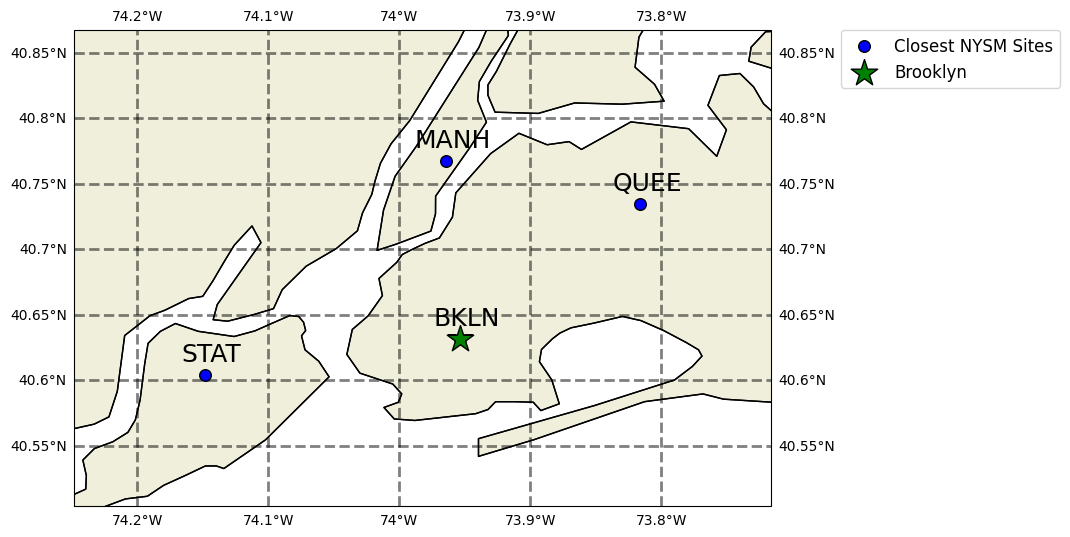

In [110]:
plot(plot_df)